# Import Packages

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence

import torchtext
from torchtext.data import get_tokenizer

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

import random
import math
import time

# Loading Data By Dataframe & Splite to Train And Test

In [2]:
def create_input_output(path):
    file_gen = read_file(path)
    poem_dict = {'In':[], 'Out':[]}
    
    for line, text in enumerate(file_gen):
        if line < 2 : continue 
        if line % 4 == 2:
            b1 = ''
            b1 = text[:-1]
        elif line % 4  == 3:
            b1 = b1 + ' / ' + text[:-1]
            poem_dict['In'].append(b1)
        elif line % 4 == 0:
            b2 = ''
            b2 = text[:-1]
        else:
            b2 = b2 + ' / ' + text[:-1]
            poem_dict['Out'].append(b2)
        
    return pd.DataFrame(poem_dict)

def read_file(path):
    with open(path) as file:
        for row in file:
            yield row
            
df = create_input_output('ferdousi.txt')
train_data, test_data = train_test_split(df, test_size=0.2)
train_data = train_data.reset_index(drop=True)
test_data = test_data.reset_index(drop=True)

train_data

,In,Out
0,همان بیخرد کو نیابد خرد / پشیمان شود هم ز گفتا...,دل مردم بیخرد به آرزوی / برین گونه آویزد ای نی...
1,زهر بر زنی مهتران را بخواند / بدور ازه بر پاسب...,وزان جایگه شد به پیش پدر / دودیده پراز آب و پر...
2,نه از تخت یاد و نه جان ارجمند / فرود آمد از با...,به دست اندرش آبگون دشنه بود / به خون پری چهرگا...
3,بکشتند ز ایرانیان بی شمار / چو نوش آذر آن دید ...,سمند سرافراز را بر نشست / بیامد یکی تیغ هندی ب...
4,بدو باز گفتند کاین رای نیست / ترا بی پدر در جه...,یکی نامه بنویس نزدیک شاه / دگر باره زو پیلتن ر...
...,...,...
19838,به فرمان یزدان چو این گفته شد / نیایش همان گه ...,بزد پر سیمرغ و بر شد به ابر / همی حلقه زد بر س...
19839,نشانندهٔ خاک در کین بخون / فشانندهٔ خنجر آبگون,از آهو همان کش سپیدست موی / بگوید سخن مردم عیب...
19840,چو ارجاسپ آمد ز خلخ به بلخ / همه زندگانی شد از...,چو ما را که پوشیده داریم روی / برهنه بیاورد ز ...
19841,خوریم آنچ داریم چیزی نخست / پس انگه جهان زیر ف...,بگسترد بر سفره بر نان نرم / یکی گور بریان بیاو...


# Create Tokenizer

In [3]:
tokenizer = get_tokenizer("basic_english")

class CustomTokenizer():
    def __init__(self, freq_threshold):
        
        self.itos = {0: "<PAD>", 1: "<SOS>", 2: "<EOS>", 3: "<UNK>"}
        self.stoi = {"<PAD>": 0, "<SOS>": 1, "<EOS>": 2, "<UNK>": 3}
        self.freq_threshold = freq_threshold

    def __len__(self):
        return len(self.itos)

    @staticmethod
    def tokenizer_eng(text):
        return [tok for tok in tokenizer(text)]

    def build_vocabulary(self, sentence_list):
        frequencies = {}
        idx = 4
        for sentence in sentence_list:
            for word in self.tokenizer_eng(sentence):
                if word not in frequencies:
                    frequencies[word] = 1

                else:
                    frequencies[word] += 1

                if frequencies[word] == self.freq_threshold:
                    self.stoi[word] = idx
                    self.itos[idx] = word
                    idx += 1

    def numericalize(self, text):
        tokenized_text = self.tokenizer_eng(text)

        return [
            self.stoi[token] if token in self.stoi else self.stoi["<UNK>"]
            for token in tokenized_text
        ]

# (A) Create Dataset Class

In [4]:
ferdousi_tokenizer = CustomTokenizer(2)

class DatasetFerdosi(Dataset):
    def __init__(self, threshold=2, train_data=None, test_data=None, vocabulary=ferdousi_tokenizer):

        self.train_data = train_data
        self.test_data = test_data

        if self.train_data is not None:
            self.data = self.train_data
        else:
            self.data = self.test_data

        self.data.rename(columns={'In': 'Input', 'Out': 'Output'}, inplace=True)

        # Initialize vocabulary and build vocab
        self.vocab = vocabulary
        input_list = self.data['Input'].to_list()
        output_list = self.data['Output'].to_list()
        input_list.extend(output_list) 
        
        if self.train_data is not None:
            self.vocab.build_vocabulary(input_list)

        self.dictionary_size = len(self.vocab.itos)
        self.PAD_IDX = self.vocab.stoi['<PAD>']

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        inp = self.data.loc[index,'Input']
        out = self.data.loc[index, 'Output']
        

        numericalized_input = [self.vocab.stoi["<SOS>"]]
        numericalized_input += self.vocab.numericalize(inp)
        numericalized_input.append(self.vocab.stoi["<EOS>"])

        numericalized_output = [self.vocab.stoi["<SOS>"]]
        numericalized_output += self.vocab.numericalize(out)
        numericalized_output.append(self.vocab.stoi["<EOS>"])
        sample = {
            'Input': torch.tensor(numericalized_input),
            'Output': torch.tensor(numericalized_output)
        }

        return sample

# (A) Loading Dataset

In [5]:
train_dataset = DatasetFerdosi(train_data=train_data)
test_dataset = DatasetFerdosi(test_data=test_data)

print(f" # Training Samples: {len(train_dataset):,}")
print(f" # Test Samples: {len(test_dataset):,}")

 # Training Samples: 19,843
 # Test Samples: 4,961


# (A) Create Collect Function For Dataloader 

In [6]:
class MyCollate():
    def __init__(self, pad_idx):
        self.pad_idx = pad_idx

    def __call__(self, batch):
        inp = [item['Input'] for item in batch]
        out = [item['Output'] for item in batch]
        Input = pad_sequence(inp, batch_first=False, padding_value=self.pad_idx)
        Output = pad_sequence(out, batch_first=False, padding_value=self.pad_idx)


        return Input, Output

# (A) Load From DataLoader

In [7]:
batch_size = 128
pad_idx = train_dataset.vocab.stoi["<PAD>"]

train_loader = DataLoader(dataset=train_dataset,
                              batch_size=batch_size,
                              shuffle=True,
                              collate_fn=MyCollate(pad_idx=pad_idx))

test_loader = DataLoader(dataset=test_dataset,
                              batch_size=batch_size,
                              shuffle=True,
                              collate_fn=MyCollate(pad_idx=pad_idx))

# (A) Create Encoder & Decoder By LSTM

In [8]:
class encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hidden_dim, n_layers, dropout):
        super().__init__()
        
        self.embedding = nn.Embedding(input_dim, emb_dim)
        self.lstm = nn.LSTM(emb_dim, hidden_dim, n_layers, dropout = dropout)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        
        x = self.embedding(x)
        x = self.dropout(x)
        outputs, (hidden, cell) = self.lstm(x)
        
        return hidden, cell
    
class decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hidden_dim, n_layers, dropout):
        super().__init__()
        
        self.output_dim = output_dim
        self.embedding = nn.Embedding(output_dim, emb_dim)
        self.fc_out = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
        self.lstm = nn.LSTM(emb_dim, hidden_dim, n_layers, dropout = dropout)

        
    def forward(self, x, hidden, cell):
        
        x = x.unsqueeze(0)
        x = self.embedding(x)
        x = self.dropout(x)
        output, (hidden, cell) = self.lstm(x, (hidden, cell))
        prediction = self.fc_out(output.squeeze(0))
        
        return prediction, hidden, cell
    
class encoder_decoder(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        
    def forward(self, src, trg, teacher_forcing_ratio = 0.5):
        
        batch_size = trg.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
        hidden, cell = self.encoder(src)
        
        input = trg[0,:]
        
        for t in range(1, trg_len):
            
            output, hidden, cell = self.decoder(input, hidden, cell)
            outputs[t] = output
            teacher_force = random.random() < teacher_forcing_ratio
            top1 = output.argmax(1) 
            input = trg[t] if teacher_force else top1
        
        return outputs
    

# (A) Load Model & Initial Weights

In [9]:
device = "cuda" if torch.cuda.is_available() else "cpu"
criterion = nn.CrossEntropyLoss(ignore_index=train_dataset.PAD_IDX)

dictionary_size = train_dataset.dictionary_size

enc = encoder(input_dim=dictionary_size, emb_dim=256, hidden_dim=512, n_layers=2, dropout=0.5)
dec = decoder(output_dim=dictionary_size, emb_dim=256, hidden_dim=512, n_layers=2, dropout=0.5)

model = encoder_decoder(enc, dec, device).to(device)
epochs = 250

optimizer = optim.Adam(model.parameters())

def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param.data, -0.08, 0.08)
        
model.apply(init_weights)

trainable_param_number = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Trainable Param Number Is : {trainable_param_number:,}")

Trainable Param Number Is : 16,774,116


# (A) Create Train & Test Loop

In [11]:
def train_loop(dataloader, model, loss_fn, optimizer, log):
    size_doc = 0
    num_batches = len(dataloader)
    train_loss, train_acc = 0, 0
    
    for batch, (X, y) in enumerate(dataloader):
        
        X = X.to(device) 
        y = y.to(device)
        
        pred = model(X, y, 1)
        output_dim = pred.shape[-1]

        loss = loss_fn(pred[1:].view(-1, pred.shape[-1]), y[1:].view(-1))
        
        m, n = y.size() 
        train_acc += (pred.argmax(dim=2) == y).sum().item()
        size_doc += (m * n)

        train_loss += loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
        optimizer.step()
        
    train_loss /= num_batches
    train_acc /= size_doc
    
    log['train_loss'].append(train_loss)
    log['train_acc'].append(train_acc)
    
    print(f"Accuracy: {(100*train_acc):>0.1f}%, Avg loss: {train_loss:>8f}") 

def test_loop(dataloader, model, loss_fn, log):
    
    size_doc = 0
    num_batches = len(dataloader)
    test_loss, test_acc, test_loss_min = 0, 0, np.Inf 
    
    with torch.no_grad():
        for X, y in dataloader:
            
            X = X.to(device) 
            y = y.to(device)

            pred = model(X, y, 0)
            output_dim = pred.shape[-1]

            loss = loss_fn(pred[1:].view(-1, pred.shape[-1]), y[1:].view(-1))

            m, n = y.size() 
            test_acc += (pred.argmax(dim=2) == y).sum().item()
            size_doc += (m * n)
            
            test_loss += loss.item()
        
    test_loss /= num_batches
    test_acc /= size_doc
    
    log['test_loss'].append(test_loss)
    log['test_acc'].append(test_acc)
    
    print(f"Accuracy: {(100*test_acc):>0.1f}%, Avg loss: {test_loss:>8f}")   

# (A) Training Process

In [12]:
log = {'train_loss':[], 'test_loss' : [], 'train_acc' : [], 'test_acc' : []}
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    model.train()
    print('Training Result : ')
    train_loop(train_loader, model, criterion, optimizer, log = log)
print("Done!")

Epoch 1
-------------------------------
Training Result : 
Accuracy: 12.3%, Avg loss: 6.100295
Epoch 2
-------------------------------
Training Result : 
Accuracy: 14.4%, Avg loss: 5.503937
Epoch 3
-------------------------------
Training Result : 
Accuracy: 15.2%, Avg loss: 5.247894
Epoch 4
-------------------------------
Training Result : 
Accuracy: 15.7%, Avg loss: 5.073139
Epoch 5
-------------------------------
Training Result : 
Accuracy: 16.4%, Avg loss: 4.893675
Epoch 6
-------------------------------
Training Result : 
Accuracy: 16.8%, Avg loss: 4.739631
Epoch 7
-------------------------------
Training Result : 
Accuracy: 17.4%, Avg loss: 4.616259
Epoch 8
-------------------------------
Training Result : 
Accuracy: 17.8%, Avg loss: 4.500440
Epoch 9
-------------------------------
Training Result : 
Accuracy: 18.3%, Avg loss: 4.397413
Epoch 10
-------------------------------
Training Result : 
Accuracy: 18.7%, Avg loss: 4.295244
Epoch 11
-------------------------------
Training

Accuracy: 46.2%, Avg loss: 1.534028
Epoch 87
-------------------------------
Training Result : 
Accuracy: 46.5%, Avg loss: 1.522324
Epoch 88
-------------------------------
Training Result : 
Accuracy: 46.6%, Avg loss: 1.512368
Epoch 89
-------------------------------
Training Result : 
Accuracy: 46.8%, Avg loss: 1.497253
Epoch 90
-------------------------------
Training Result : 
Accuracy: 47.1%, Avg loss: 1.483271
Epoch 91
-------------------------------
Training Result : 
Accuracy: 47.1%, Avg loss: 1.469312
Epoch 92
-------------------------------
Training Result : 
Accuracy: 47.3%, Avg loss: 1.460791
Epoch 93
-------------------------------
Training Result : 
Accuracy: 47.5%, Avg loss: 1.446696
Epoch 94
-------------------------------
Training Result : 
Accuracy: 47.5%, Avg loss: 1.433382
Epoch 95
-------------------------------
Training Result : 
Accuracy: 47.8%, Avg loss: 1.424136
Epoch 96
-------------------------------
Training Result : 
Accuracy: 48.1%, Avg loss: 1.410036
Epoc

Accuracy: 57.3%, Avg loss: 0.751487
Epoch 172
-------------------------------
Training Result : 
Accuracy: 57.4%, Avg loss: 0.740588
Epoch 173
-------------------------------
Training Result : 
Accuracy: 57.3%, Avg loss: 0.732132
Epoch 174
-------------------------------
Training Result : 
Accuracy: 57.8%, Avg loss: 0.725886
Epoch 175
-------------------------------
Training Result : 
Accuracy: 57.6%, Avg loss: 0.724027
Epoch 176
-------------------------------
Training Result : 
Accuracy: 57.6%, Avg loss: 0.713718
Epoch 177
-------------------------------
Training Result : 
Accuracy: 57.7%, Avg loss: 0.712920
Epoch 178
-------------------------------
Training Result : 
Accuracy: 57.6%, Avg loss: 0.706222
Epoch 179
-------------------------------
Training Result : 
Accuracy: 58.0%, Avg loss: 0.700023
Epoch 180
-------------------------------
Training Result : 
Accuracy: 58.1%, Avg loss: 0.694478
Epoch 181
-------------------------------
Training Result : 
Accuracy: 58.2%, Avg loss: 0.6

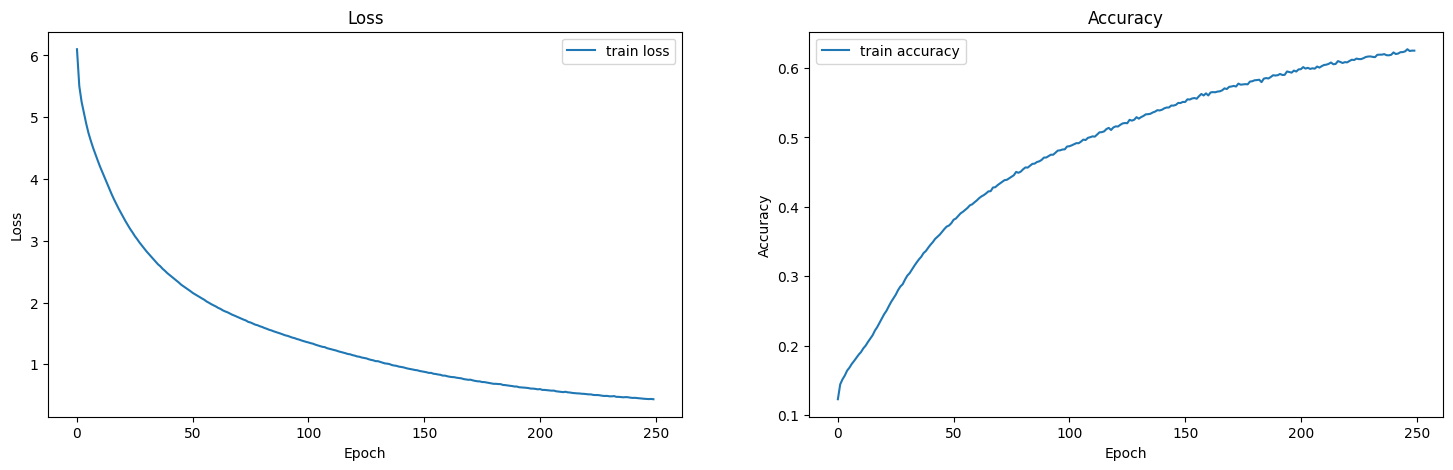

In [13]:
n_epochs = [*range(epochs)]
plt.figure(figsize=(18,5))
plt.subplot(121)
plt.plot(n_epochs, log['train_loss'])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title('Loss')
plt.legend(['train loss', 'test loss'])
plt.subplot(122)
plt.plot(n_epochs, log['train_acc'])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title('Accuracy')
plt.legend(['train accuracy', 'test accuracy'])

# (A) Generative Function

In [14]:
def poem_generation(model, index_beyt):
    
    model.eval()
    dic = test_dataset[index_beyt]
    
    X = dic['Input']
    y = dic['Output']
    
    with torch.no_grad():
        X = X.to(device)
        X = torch.reshape(X, (len(X), 1))

        y = y.to(device)
        y = torch.reshape(y, (len(y), 1))

        pred = model(X, y, 0)
        pred = pred[1:].view(-1, pred.shape[-1])

        pred = (pred.argmax(dim=1))

        list_poem_word = []
        lst = ["<PAD>", "<SOS>", "<EOS>", "<UNK>"]

        for i in range(len(pred)):
            if train_dataset.vocab.itos[pred[i].item()] not in lst:
                list_poem_word.append(train_dataset.vocab.itos[pred[i].item()])
        d = ' '.join(list_poem_word)
        return d

In [22]:
Beyt_number_of_dataset = 250
print(f"Input Beyt: {test_dataset.data.loc[Beyt_number_of_dataset,'Input']}")
print(f"Output Beyt: {poem_generation(model, Beyt_number_of_dataset)}")

Input Beyt: بیامد بسان نهنگ دژم / که گفتی زمین را بسوزد بدم
Output Beyt: بیامد سوی قلب کوه اندرون / بگفت آمد از کار بد رهنمون


# (B) GRU

In [23]:
class encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hidden_dim, dropout):
        super().__init__()
        
        self.embedding = nn.Embedding(input_dim, emb_dim)
        self.gru = nn.GRU(emb_dim, hidden_dim, bidirectional = True)
        self.fc = nn.Linear(hidden_dim * 2, hidden_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
    
        x = self.embedding(x)
        x = self.dropout(x)
        outputs, hidden = self.gru(x)
        hidden = torch.tanh(self.fc(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)))
        
        return outputs, hidden

class Attention(nn.Module):
    
    def __init__(self, hidden_dim):
        super().__init__()
        
        self.attn = nn.Linear((hidden_dim * 2) + hidden_dim, hidden_dim)
        self.v = nn.Linear(hidden_dim, 1, bias = False)
        
    def forward(self, hidden, encoder_outputs):
        
        batch_size = encoder_outputs.shape[1]
        src_len = encoder_outputs.shape[0]
        hidden = hidden.unsqueeze(1).repeat(1, src_len, 1)
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim = 2))) 
        attention = self.v(energy).squeeze(2)
        
        return F.softmax(attention, dim=1)

class decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hidden_dim, dropout, attention):
        super().__init__()

        self.output_dim = output_dim
        self.attention = attention
        self.embedding = nn.Embedding(output_dim, emb_dim)
        self.rnn = nn.GRU((hidden_dim * 2) + emb_dim, hidden_dim)
        self.fc_out = nn.Linear((hidden_dim * 2) + hidden_dim + emb_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, hidden, encoder_outputs):

        x = x.unsqueeze(0)   
        x = self.embedding(x)
        x = self.dropout(x)        
        a = self.attention(hidden, encoder_outputs)
        a = a.unsqueeze(1)
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        weighted = torch.bmm(a, encoder_outputs)
        weighted = weighted.permute(1, 0, 2)
        rnn_input = torch.cat((x, weighted), dim = 2)
        output, hidden = self.rnn(rnn_input, hidden.unsqueeze(0))
        assert (output == hidden).all()
        x = x.squeeze(0)
        output = output.squeeze(0)
        weighted = weighted.squeeze(0)
        prediction = self.fc_out(torch.cat((output, weighted, x), dim = 1))
        
        return prediction, hidden.squeeze(0)
    
class encoder_decoder(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        
    def forward(self, src, trg, teacher_forcing_ratio = 0.5):
        
        batch_size = src.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
        encoder_outputs, hidden = self.encoder(src)
        input = trg[0,:]
        
        for t in range(1, trg_len):

            output, hidden = self.decoder(input, hidden, encoder_outputs)
            outputs[t] = output
            teacher_force = random.random() < teacher_forcing_ratio
            top1 = output.argmax(1) 
            input = trg[t] if teacher_force else top1

        return outputs

# (B) Load Model & Initial Weights

In [24]:
device = "cuda" if torch.cuda.is_available() else "cpu"
criterion = nn.CrossEntropyLoss(ignore_index=train_dataset.PAD_IDX)

dictionary_size = train_dataset.dictionary_size

attention = Attention(hidden_dim=512)
enc = encoder(input_dim=dictionary_size, emb_dim=256, hidden_dim=512, dropout=0.5)
dec = decoder(output_dim=dictionary_size, emb_dim=256, hidden_dim=512, dropout=0.5, attention=attention)

model = encoder_decoder(enc, dec, device).to(device)
epochs = 50

optimizer = optim.Adam(model.parameters())

def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param.data, -0.08, 0.08)
        
model.apply(init_weights)

trainable_param_number = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Trainable Param Number Is : {trainable_param_number:,}")

Trainable Param Number Is : 27,611,620


# (B) Create Train & Test Loop

In [25]:
def train_loop(dataloader, model, loss_fn, optimizer, log):
    size_doc = 0
    num_batches = len(dataloader)
    train_loss, train_acc = 0, 0
    
    for batch, (X, y) in enumerate(dataloader):
        
        X = X.to(device) 
        y = y.to(device)
        
        pred = model(X, y, 1)
        output_dim = pred.shape[-1]

        loss = loss_fn(pred[1:].view(-1, pred.shape[-1]), y[1:].view(-1))
        
        m, n = y.size() 
        train_acc += (pred.argmax(dim=2) == y).sum().item()
        size_doc += (m * n)

        train_loss += loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
        optimizer.step()
        
    train_loss /= num_batches
    train_acc /= size_doc
    
    log['train_loss'].append(train_loss)
    log['train_acc'].append(train_acc)
    
    print(f"Accuracy: {(100*train_acc):>0.1f}%, Avg loss: {train_loss:>8f}") 

def test_loop(dataloader, model, loss_fn, log):
    
    size_doc = 0
    num_batches = len(dataloader)
    test_loss, test_acc, test_loss_min = 0, 0, np.Inf 
    
    with torch.no_grad():
        for X, y in dataloader:
            
            X = X.to(device) 
            y = y.to(device)

            pred = model(X, y, 0)
            output_dim = pred.shape[-1]

            loss = loss_fn(pred[1:].view(-1, pred.shape[-1]), y[1:].view(-1))

            m, n = y.size() 
            test_acc += (pred.argmax(dim=2) == y).sum().item()
            size_doc += (m * n)
            
            test_loss += loss.item()
        
    test_loss /= num_batches
    test_acc /= size_doc
    
    log['test_loss'].append(test_loss)
    log['test_acc'].append(test_acc)
    
    print(f"Accuracy: {(100*test_acc):>0.1f}%, Avg loss: {test_loss:>8f}")   

# (B) Training Process

In [26]:
log = {'train_loss':[], 'test_loss' : [], 'train_acc' : [], 'test_acc' : []}
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    model.train()
    print('Training Result : ')
    train_loop(train_loader, model, criterion, optimizer, log = log)
print("Done!")

Epoch 1
-------------------------------
Training Result : 
Accuracy: 13.2%, Avg loss: 5.927160
Epoch 2
-------------------------------
Training Result : 
Accuracy: 16.5%, Avg loss: 5.162429
Epoch 3
-------------------------------
Training Result : 
Accuracy: 18.0%, Avg loss: 4.783786
Epoch 4
-------------------------------
Training Result : 
Accuracy: 19.4%, Avg loss: 4.440002
Epoch 5
-------------------------------
Training Result : 
Accuracy: 20.9%, Avg loss: 4.094584
Epoch 6
-------------------------------
Training Result : 
Accuracy: 22.8%, Avg loss: 3.722635
Epoch 7
-------------------------------
Training Result : 
Accuracy: 25.5%, Avg loss: 3.348143
Epoch 8
-------------------------------
Training Result : 
Accuracy: 28.9%, Avg loss: 2.972170
Epoch 9
-------------------------------
Training Result : 
Accuracy: 32.2%, Avg loss: 2.629655
Epoch 10
-------------------------------
Training Result : 
Accuracy: 35.4%, Avg loss: 2.342768
Epoch 11
-------------------------------
Training

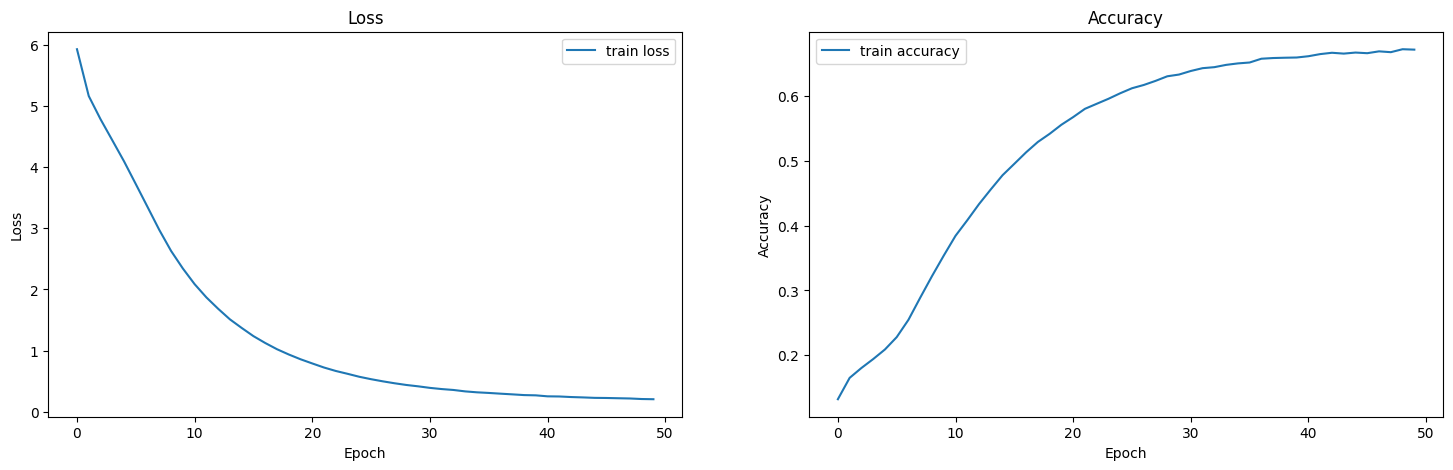

In [27]:
n_epochs = [*range(epochs)]
plt.figure(figsize=(18,5))
plt.subplot(121)
plt.plot(n_epochs, log['train_loss'])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title('Loss')
plt.legend(['train loss', 'test loss'])
plt.subplot(122)
plt.plot(n_epochs, log['train_acc'])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title('Accuracy')
plt.legend(['train accuracy', 'test accuracy'])

# (B) Generative Result

In [28]:
Beyt_number_of_dataset = 250
print(f"Input Beyt: {test_dataset.data.loc[Beyt_number_of_dataset,'Input']}")
print(f"Output Beyt: {poem_generation(model, Beyt_number_of_dataset)}")

Input Beyt: بیامد بسان نهنگ دژم / که گفتی زمین را بسوزد بدم
Output Beyt: میان دو لشکر همی چاره دار / ازین پس چو خورشید تابان گذشت


# (B) Conclusion

By comparing the results of GRU & LSTM, It shown that works better than LSTM